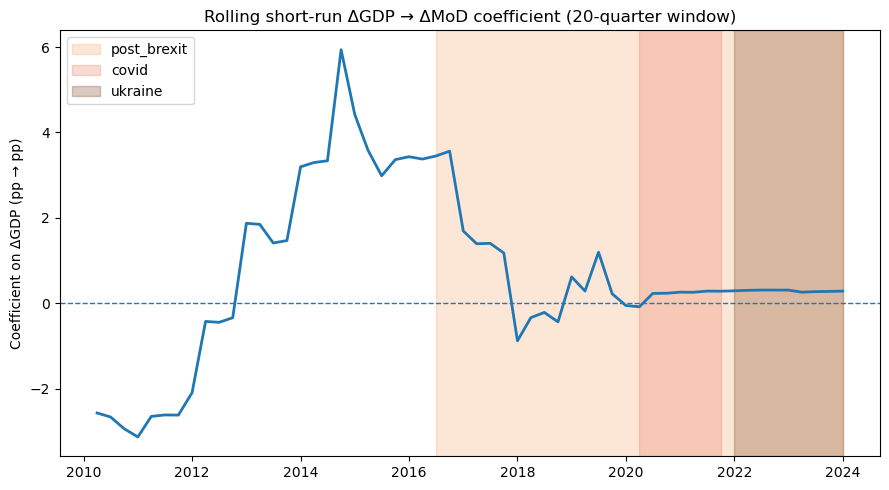

=== Provenance ===
loaded_processed:master_panel_phaseC_rebuild.csv
gdp_real:from_abmi_q:abmi_q.csv

=== Series chosen ===
Dependent (y_level): existing → positive & logged
Regressor (x_level): constructed → positive & logged

=== Cointegration ===
Saved OLS summary → figures\tables\phaseD\RQ3_cointegration_levels_ols_summary.txt


,F,df1,df2,pval,test,event,break_at
0,11.259111,2,76,5.215394e-05,cointegration_chow,post_brexit,2016Q3
1,52.211355,2,76,5.440093e-15,cointegration_chow,covid,2020Q2
2,27.727479,2,76,9.065495e-10,cointegration_chow,ukraine,2022Q1



=== ECM ===
Lag search (AIC): py=4, px=4
Baseline ECM summary → figures\tables\phaseD\RQ3_ecm_baseline_summary.txt
Interactions ECM summary → figures\tables\phaseD\RQ3_ecm_interactions_summary.txt


,effect,event,estimate_pp,se,F,pval,estimate
0,short_run_dx_pp,post_brexit,0.225392,0.647668,0.121107,0.729096,NaN
1,short_run_dx_pp,covid,-0.097582,0.799312,0.014904,0.903255,NaN
2,short_run_dx_pp,ukraine,0.375307,2.047268,0.033607,0.855186,NaN
3,speed_of_adjustment,post_brexit,NaN,9.419544,0.047505,0.828228,-2.053046
4,speed_of_adjustment,covid,NaN,33.077867,0.461705,0.499531,-22.476032
5,speed_of_adjustment,ukraine,NaN,14.952439,1.400694,0.241436,-17.696348



=== Stability ===
ECM Chow at events → figures\tables\phaseD\RQ3_chow_ecm_at_events.csv
CUSUM p-value saved → figures\tables\phaseD\RQ3_cusum_pooled_ecm.txt

=== Rolling coefficient figure saved → figures\phaseD\RQ3_rolling_dx_to_dy_coefficient.png


In [1]:
# ============================================================
# Phase D — RQ2

import os, glob, json, math, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from statsmodels.stats.diagnostic import breaks_cusumolsresid
from scipy.stats import f as f_dist
from IPython.display import display

warnings.filterwarnings("ignore")

# ==============================
# Config & Event Windows
# ==============================
MAX_LAGS = 4
ROLLING_WINDOW = 20

OUT_FIG_DIR = Path("figures/phaseD"); OUT_FIG_DIR.mkdir(parents=True, exist_ok=True)
OUT_TAB_DIR = Path("figures/tables/phaseD"); OUT_TAB_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIAG_DIR = Path("figures/tables/phaseD"); OUT_DIAG_DIR.mkdir(parents=True, exist_ok=True)

# Priority for dependent (you can swap to 'mod_cap_real' or 'mod_cur_real' later)
Y_PRIORITY = ["mod_total_real","defence_total_real","mod_real_total"]
# Acceptable synonyms for GDP real levels
X_PRIORITY = ["gdp_real_abmi","gdp_real","abmi","gdp_cvm_mn","gdp_cvm","gdp_chained_volume","gdp_real_mn_autogen"]

# Event windows (inclusive)
EVENTS = {
    "post_brexit": {"start": "2016Q3", "end": None},
    "covid":       {"start": "2020Q2", "end": "2021Q4"},
    "ukraine":     {"start": "2022Q1", "end": None},
}

# DISTINCT, HIGH-CONTRAST FILLS (only change requested)
EVENT_COLORS = {
    "post_brexit": "#F4A261",  # orange
    "covid":       "#E76F51",  # terracotta red
    "ukraine":     "#6E2C00",  # deep brown (darker, higher-contrast than terracotta)
}
EVENT_ALPHA = {"post_brexit": 0.25, "covid": 0.25, "ukraine": 0.25}

# ==============================
# Small Utilities
# ==============================
def _latest_file(cands):
    hits = []
    for pat in cands:
        pat = os.path.expandvars(os.path.expanduser(str(pat)))
        for m in glob.glob(pat):
            p = Path(m)
            try: _ = p.stat().st_mtime
            except FileNotFoundError: continue
            hits.append(p)
    return max(hits, key=lambda p: p.stat().st_mtime) if hits else None

def _read_any(path: Path):
    if path.suffix.lower() == ".parquet":
        try: return pd.read_parquet(path)
        except Exception as e: raise RuntimeError(f"Failed to read parquet: {path}\n{e}")
    else:
        return pd.read_csv(path)

def _guess_period_q(df):
    candidates = ["quarter","period","date","time","qtr","quarter_period"]
    col = next((c for c in candidates if c in df.columns), None)
    if col is not None:
        s = df[col]
        if np.issubdtype(s.dtype, np.datetime64):
            return s.dt.to_period("Q")
        ss = s.astype(str).str.replace("-", "", regex=False).str.replace(" ", "", regex=False)
        return pd.PeriodIndex(ss, freq="Q")
    yc = next((c for c in df.columns if "year" in c.lower()), None)
    qc = next((c for c in df.columns if "quarter" in c.lower() or c.lower()=="q"), None)
    if yc and qc:
        return pd.PeriodIndex(df[yc].astype(int).astype(str) + "Q" + df[qc].astype(int).astype(str), freq="Q")
    raise KeyError("Could not infer quarterly period index; please include 'quarter/period/date' or 'year+quarter'.")

def _pick_col(df, names):
    for n in names:
        if n in df.columns: return n
        eq = [c for c in df.columns if c.lower()==n.lower()]
        if eq: return eq[0]
    return None

def _make_event_dummies(idx, events):
    d = {}
    for name, win in events.items():
        s = pd.Period(win["start"], freq="Q")
        e = pd.Period(win["end"], freq="Q") if win["end"] else None
        d[name] = ((idx >= s) if e is None else ((idx >= s) & (idx <= e))).astype(int)
    return pd.DataFrame(d, index=idx)

def _chow_test(y, X, break_loc):
    n, k = len(y), X.shape[1]
    if break_loc <= k or (n - break_loc) <= k:
        return {"F": np.nan, "df1": k, "df2": n - 2*k, "pval": np.nan, "note":"Insufficient obs"}
    resR = sm.OLS(y, X).fit()
    RSSr = float(np.sum(resR.resid**2))
    y1, X1 = y.iloc[:break_loc], X.iloc[:break_loc, :]
    y2, X2 = y.iloc[break_loc:], X.iloc[break_loc:, :]
    res1 = sm.OLS(y1, X1).fit()
    res2 = sm.OLS(y2, X2).fit()
    RSSu = float(np.sum(res1.resid**2) + np.sum(res2.resid**2))
    df1, df2 = k, n - 2*k
    if df2 <= 0:
        return {"F": np.nan, "df1": df1, "df2": df2, "pval": np.nan, "note":"Non-positive df2"}
    F = ((RSSr - RSSu)/df1) / (RSSu/df2)
    p = 1 - f_dist.cdf(F, df1, df2)
    return {"F": F, "df1": df1, "df2": df2, "pval": p}

def _best_ecm_lags(dy, dx, ecm_lag, max_lags=4, ic="aic"):
    best, best_ic = None, np.inf
    for py in range(0, max_lags+1):
        for px in range(0, max_lags+1):
            tmp = pd.DataFrame({"dy":dy, "dx0":dx, "ecm_lag":ecm_lag})
            for i in range(1, py+1): tmp[f"dy_l{i}"] = tmp["dy"].shift(i)
            for j in range(1, px+1): tmp[f"dx_l{j}"] = tmp["dx0"].shift(j)
            tmp = tmp.dropna()
            if len(tmp) < 30: continue
            Y = tmp["dy"]
            Xcols = ["ecm_lag","dx0"] + [c for c in tmp.columns if c.startswith("dy_l") or c.startswith("dx_l")]
            X = sm.add_constant(tmp[Xcols])
            res = sm.OLS(Y, X).fit()
            score = res.aic if ic.lower()=="aic" else res.bic
            if score < best_ic:
                best_ic = score; best = (py, px, res, Xcols)
    return best

def _wald_sum_test(res, names):
    params, cov = res.params, res.cov_params()
    picks = [n for n in names if n in params.index]
    if not picks: return (np.nan, np.nan, np.nan, np.nan)
    w = np.zeros((len(params),))
    for n in picks: w[params.index.get_loc(n)] = 1.0
    est = float(np.dot(w, params))
    var = float(np.dot(w, cov @ w))
    se  = math.sqrt(var) if var>=0 else np.nan
    F = (est**2)/var if var>0 else np.nan
    p = 1 - f_dist.cdf(F, 1, int(res.df_resid)) if not np.isnan(F) else np.nan
    return est, se, F, p

# ==============================
# Load processed panel or build from interim if needed
# ==============================
INTERIM = Path("data/interim")
PROCESSED = Path("data/processed")

processed_choice = _latest_file([
    PROCESSED / "master_panel_*.parquet",
    PROCESSED / "master_panel_*.csv",
    PROCESSED / "master_panel.parquet",
    PROCESSED / "master_panel.csv",
    PROCESSED / "ardl_ready_panel.parquet",
    PROCESSED / "ardl_ready_panel.csv",
])

provenance = []
if processed_choice is not None:
    df0 = _read_any(processed_choice).copy()
    provenance.append(f"loaded_processed:{processed_choice.name}")
else:
    df0 = pd.DataFrame()
    provenance.append("no_processed_found")

if not df0.empty:
    try:
        idx = _guess_period_q(df0)
        df0.index = idx
        df0 = df0.sort_index()
    except Exception:
        pass

y_col = _pick_col(df0, Y_PRIORITY) if not df0.empty else None
x_col = _pick_col(df0, X_PRIORITY) if not df0.empty else None

# ---------- Fallback build: GDP real ----------
def _load_quarter_series(fp, period_col_guess=None, value_col_guess=None):
    d = _read_any(fp)
    valc = value_col_guess
    if valc is None:
        numcols = [c for c in d.columns if pd.api.types.is_numeric_dtype(d[c])]
        if not numcols and "value" in d.columns:
            d["value"] = pd.to_numeric(d["value"], errors="coerce"); numcols = ["value"]
        valc = numcols[0]
    if period_col_guess is None:
        per_cands = ["quarter","period","date","time","qtr"]
        per = next((c for c in per_cands if c in d.columns), None)
    else:
        per = period_col_guess
    idx = _guess_period_q(d.rename(columns={per:"period"}) if per!="period" else d)
    out = pd.DataFrame({"value": d[valc].values}, index=idx)
    out = out[~out.index.duplicated(keep="last")]
    return out.sort_index()

gdp_real = None
if x_col is None:
    abmi = _latest_file([INTERIM/"abmi_q*.csv", INTERIM/"abmi_q*.parquet", Path("/mnt/data/abmi_q.csv")])
    if abmi:
        s = _load_quarter_series(abmi)
        gdp_real = s.rename(columns={"value":"gdp_real_abmi"})
        provenance.append(f"gdp_real:from_abmi_q:{abmi.name}")
    else:
        ybha = _latest_file([INTERIM/"ybha_q*.csv", Path("/mnt/data/ybha_q.csv")])
        ybgb = _latest_file([INTERIM/"ybgb_q*.csv", Path("/mnt/data/ybgb_q.csv")])
        if ybha and ybgb:
            s_nom = _load_quarter_series(ybha).rename(columns={"value":"gdp_nominal_ybha"})
            s_def = _load_quarter_series(ybgb).rename(columns={"value":"gdp_deflator_ybgb"})
            tmp = s_nom.join(s_def, how="inner")
            tmp["gdp_real_abmi"] = tmp["gdp_nominal_ybha"] / (tmp["gdp_deflator_ybgb"]/100.0)
            gdp_real = tmp[["gdp_real_abmi"]]
            provenance.append(f"gdp_real:constructed_from_ybha_ybgb:{ybha.name}|{ybgb.name}")

# ---------- Fallback build: MoD real total ----------
mod_real = None
if y_col is None:
    dn_w = _latest_file([INTERIM/"defence_q_nominal_wide*.csv", Path("/mnt/data/defence_q_nominal_wide.csv")])
    cpihq = _latest_file([INTERIM/"cpih_quarterly*.csv", Path("/mnt/data/cpih_quarterly.csv")])
    if dn_w is not None and cpihq is not None:
        nom = _read_any(dn_w)
        nom_cols = [c for c in nom.columns if c.lower() in ["total","mod_total_nominal","defence_total_nominal","mod_total","total_nominal"]]
        if not nom_cols:
            numcols = [c for c in nom.columns if pd.api.types.is_numeric_dtype(nom[c])]
            if numcols: nom_cols = [numcols[0]]
        if "quarter" in nom.columns:
            nom_idx = _guess_period_q(nom); nom = nom.set_index(nom_idx).sort_index()
        else:
            nom_idx = _guess_period_q(nom.rename(columns={nom.columns[0]:"quarter"}))
            nom.index = nom_idx; nom = nom.sort_index()
        total_nom = nom[nom_cols[0]].to_frame("mod_total_nominal")
        cp = _load_quarter_series(cpihq).rename(columns={"value":"cpih_q"})
        merged = total_nom.join(cp, how="inner")
        merged["mod_total_real"] = merged["mod_total_nominal"] / (merged["cpih_q"]/100.0)
        mod_real = merged[["mod_total_real"]]
        provenance.append(f"mod_total_real:deflated_with_cpiq:{dn_w.name}|{cpihq.name}")
    else:
        dn_l = _latest_file([INTERIM/"defence_q_nominal_long*.csv", Path("/mnt/data/defence_q_nominal_long.csv")])
        if dn_l and cpihq:
            dlong = _read_any(dn_l)
            qcol = next((c for c in dlong.columns if c.lower() in ["quarter","period","date","time"]), None)
            vcol = next((c for c in dlong.columns if pd.api.types.is_numeric_dtype(dlong[c])), None)
            if qcol is None or vcol is None:
                raise RuntimeError("defence_q_nominal_long could not be parsed (need quarter+value).")
            dlong = dlong.rename(columns={qcol:"quarter", vcol:"value"})
            dlong["quarter"] = pd.PeriodIndex(pd.to_datetime(dlong["quarter"]).to_period("Q"), freq="Q")
            nom_tot = dlong.groupby("quarter", as_index=True)["value"].sum().to_frame("mod_total_nominal").sort_index()
            cp = _load_quarter_series(cpihq).rename(columns={"value":"cpih_q"})
            merged = nom_tot.join(cp, how="inner")
            merged["mod_total_real"] = merged["mod_total_nominal"] / (merged["cpih_q"]/100.0)
            mod_real = merged[["mod_total_real"]]
            provenance.append(f"mod_total_real:deflated_long_with_cpiq:{dn_l.name}|{cpihq.name}")

# ---------- Assemble working df ----------
work = pd.DataFrame()
if not df0.empty:
    try:
        idx = _guess_period_q(df0)
        df0.index = idx; df0 = df0[~df0.index.duplicated(keep="last")].sort_index()
        work = df0.copy()
    except Exception:
        pass

if x_col:
    work["x_level"] = work[x_col].astype(float)
else:
    if gdp_real is None: raise KeyError("Real GDP not found in processed panel and could not construct from interim files.")
    work = work.join(gdp_real, how="outer"); work["x_level"] = work["gdp_real_abmi"].astype(float)

if y_col:
    work["y_level"] = work[y_col].astype(float)
else:
    if mod_real is None:
        ade = _latest_file([INTERIM/"Annual Defence Expenditure - Combined_tidy*.csv", Path("/mnt/data/Annual Defence Expenditure - Combined_tidy.csv")])
        if ade:
            tmp = _read_any(ade)
            qcol = next((c for c in tmp.columns if c.lower() in ["quarter","period","date","time"]), None)
            rcol = next((c for c in tmp.columns if "real" in c.lower() and "total" in c.lower()), None)
            if qcol and rcol:
                tmp = tmp.rename(columns={qcol:"quarter"})
                tmp_idx = _guess_period_q(tmp)
                mod_real = pd.DataFrame({"mod_total_real": pd.to_numeric(tmp[rcol], errors="coerce").values}, index=tmp_idx).sort_index()
                provenance.append(f"mod_total_real:from_ADE_combined:{ade.name}")
    if mod_real is None: raise KeyError("MoD real total not found in processed panel and could not construct from interim files.")
    work = work.join(mod_real, how="outer"); work["y_level"] = work["mod_total_real"].astype(float)

work = work[["y_level","x_level"]].dropna().copy()
work.index = pd.PeriodIndex(work.index, freq="Q")
work = work.sort_index()

# ==============================
# Transformations & Events
# ==============================
if (work <= 0).any().any():
    raise ValueError("Non-positive values found in levels; logs require positive series.")

work["ly"] = np.log(work["y_level"])
work["lx"] = np.log(work["x_level"])
work["dy_pp"] = work["ly"].diff() * 100.0
work["dx_pp"] = work["lx"].diff() * 100.0

D = _make_event_dummies(work.index, EVENTS)
work = work.join(D)

# ==============================
# Step 1: Cointegration & Chow
# ==============================
coin_df = work[["ly","lx"]].dropna()
cX = sm.add_constant(coin_df["lx"])
cRes = sm.OLS(coin_df["ly"], cX).fit()
with open(OUT_TAB_DIR/"RQ3_cointegration_levels_ols_summary.txt","w") as f:
    f.write(cRes.summary().as_text())

chow_rows = []
for ev, win in EVENTS.items():
    bp = pd.Period(win["start"], freq="Q")
    if bp not in coin_df.index:
        chow_rows.append({"test":"cointegration_chow","event":ev,"break_at":str(bp),"F":np.nan,"df1":np.nan,"df2":np.nan,"pval":np.nan,"note":"break not in sample"})
    else:
        k = coin_df.index.get_loc(bp)
        res = _chow_test(coin_df["ly"], sm.add_constant(coin_df["lx"]), k)
        res.update({"test":"cointegration_chow","event":ev,"break_at":str(bp)})
        chow_rows.append(res)
coin_chow_tab = pd.DataFrame(chow_rows)
coin_chow_tab.to_csv(OUT_TAB_DIR/"RQ3_chow_cointegration_at_events.csv", index=False)

# ==============================
# Step 2: ECM baseline (lag search)
# ==============================
work["u_ecm"] = work["ly"] - (cRes.params["const"] + cRes.params["lx"]*work["lx"])
work["u_ecm_l1"] = work["u_ecm"].shift(1)
ecm_base = work[["dy_pp","dx_pp","u_ecm_l1"]].dropna()

best = _best_ecm_lags(ecm_base["dy_pp"], ecm_base["dx_pp"], ecm_base["u_ecm_l1"], max_lags=MAX_LAGS, ic="aic")
if best is None: raise RuntimeError("Lag search failed (insufficient data after differencing/lags).")
py, px, ecm_res_baseline, Xcols_base = best
with open(OUT_TAB_DIR/"RQ3_ecm_baseline_summary.txt","w") as f:
    f.write(ecm_res_baseline.summary().as_text())

# ==============================
# Step 3: ECM with event interactions
# ==============================
def _build_ecm_design(df, py, px):
    dd = pd.DataFrame({
        "dy": df["dy_pp"],
        "dx0": df["dx_pp"],
        "ecm_lag": df["u_ecm_l1"]
    }, index=df.index)
    for i in range(1, py+1): dd[f"dy_l{i}"] = dd["dy"].shift(i)
    for j in range(1, px+1): dd[f"dx_l{j}"] = dd["dx0"].shift(j)
    return dd.join(D).dropna()

DD = _build_ecm_design(work, py, px)

for ev in EVENTS.keys():
    DD[f"dx0_x_{ev}"] = DD["dx0"] * DD[ev]
    DD[f"ecm_x_{ev}"] = DD["ecm_lag"] * DD[ev]

Y = DD["dy"]
X_base = ["ecm_lag","dx0"] + [c for c in DD.columns if c.startswith("dy_l") or c.startswith("dx_l")]
X_int  = X_base + [f"dx0_x_{ev}" for ev in EVENTS] + [f"ecm_x_{ev}" for ev in EVENTS]

res_int = sm.OLS(Y, sm.add_constant(DD[X_int])).fit()
with open(OUT_TAB_DIR/"RQ3_ecm_interactions_summary.txt","w") as f:
    f.write(res_int.summary().as_text())

wald_rows = []
for ev in EVENTS.keys():
    est, se, F, p = _wald_sum_test(res_int, ["dx0", f"dx0_x_{ev}"])
    wald_rows.append({"effect":"short_run_dx_pp","event":ev,"estimate_pp":est,"se":se,"F":F,"pval":p})
for ev in EVENTS.keys():
    est, se, F, p = _wald_sum_test(res_int, ["ecm_lag", f"ecm_x_{ev}"])
    wald_rows.append({"effect":"speed_of_adjustment","event":ev,"estimate":est,"se":se,"F":F,"pval":p})
wald_tab = pd.DataFrame(wald_rows)
wald_tab.to_csv(OUT_TAB_DIR/"RQ3_wald_effects_interactions.csv", index=False)

# ==============================
# Step 4: Chow on ECM at event dates
# ==============================
DD_pooled = _build_ecm_design(work, py, px)
Yp = DD_pooled["dy"]
Xp = sm.add_constant(DD_pooled[[c for c in DD_pooled.columns if c=="ecm_lag" or c=="dx0" or c.startswith("dy_l") or c.startswith("dx_l")]])
res_pool = sm.OLS(Yp, Xp).fit()

ecm_chow_rows = []
for ev, win in EVENTS.items():
    bp = pd.Period(win["start"], freq="Q")
    if bp not in DD_pooled.index:
        ecm_chow_rows.append({"test":"ecm_chow","event":ev,"break_at":str(bp),"F":np.nan,"df1":np.nan,"df2":np.nan,"pval":np.nan,"note":"break not in sample"})
    else:
        k = DD_pooled.index.get_loc(bp)
        res = _chow_test(Yp, Xp, k)
        res.update({"test":"ecm_chow","event":ev,"break_at":str(bp)})
        ecm_chow_rows.append(res)
ecm_chow_tab = pd.DataFrame(ecm_chow_rows)
ecm_chow_tab.to_csv(OUT_TAB_DIR/"RQ3_chow_ecm_at_events.csv", index=False)

# ==============================
# Step 5: CUSUM
# ==============================
_, cusum_pval, _ = breaks_cusumolsresid(res_pool.resid, ddof=len(res_pool.params))
with open(OUT_DIAG_DIR/"RQ3_cusum_pooled_ecm.txt","w") as f:
    f.write(f"CUSUM p-value (H0: no structural change) = {cusum_pval:.4f}\n")

# ==============================
# Step 6: Rolling ΔGDP coefficient with high-contrast shading (only visual change)
# ==============================
roll_X = ["dx0"] + [c for c in DD_pooled.columns if c.startswith("dy_l") or c.startswith("dx_l") or c=="ecm_lag"]
roll_df = DD_pooled[["dy"] + roll_X].dropna()
rolling = RollingOLS(roll_df["dy"], sm.add_constant(roll_df[roll_X]), window=ROLLING_WINDOW).fit()
beta_dx = rolling.params["dx0"]; beta_dx.index = roll_df.index

import matplotlib.patches as mpatches
plt.figure(figsize=(9,5))
plt.plot(beta_dx.index.to_timestamp(), beta_dx, linewidth=2, zorder=2)

for ev, win in EVENTS.items():
    start = pd.Period(win["start"], freq="Q").to_timestamp()
    end = pd.Period(win["end"], freq="Q").to_timestamp() if win["end"] else beta_dx.index.to_timestamp()[-1]
    plt.axvspan(start, end, color=EVENT_COLORS.get(ev, "#BBBBBB"), alpha=EVENT_ALPHA.get(ev, 0.25), zorder=0)

plt.axhline(0, linestyle="--", linewidth=1, zorder=1)
plt.title(f"Rolling short-run ΔGDP → ΔMoD coefficient ({ROLLING_WINDOW}-quarter window)")
plt.ylabel("Coefficient on ΔGDP (pp → pp)")

handles = [
    mpatches.Patch(color=EVENT_COLORS["post_brexit"], alpha=EVENT_ALPHA["post_brexit"], label="post_brexit"),
    mpatches.Patch(color=EVENT_COLORS["covid"],       alpha=EVENT_ALPHA["covid"],       label="covid"),
    mpatches.Patch(color=EVENT_COLORS["ukraine"],     alpha=EVENT_ALPHA["ukraine"],     label="ukraine"),
]
plt.legend(handles=handles, loc="best")
plt.tight_layout()
roll_path = OUT_FIG_DIR/"RQ3_rolling_dx_to_dy_coefficient.png"
plt.savefig(roll_path, dpi=200, bbox_inches="tight"); plt.show()

# ==============================
# Lightweight dashboard in-cell
# ==============================
print("=== Provenance ===")
print("\n".join(provenance))
print("\n=== Series chosen ===")
print("Dependent (y_level):", "existing" if _pick_col(df0, Y_PRIORITY) else "constructed", "→ positive & logged")
print("Regressor (x_level):", "existing" if _pick_col(df0, X_PRIORITY) else "constructed", "→ positive & logged")
print("\n=== Cointegration ===")
print("Saved OLS summary →", OUT_TAB_DIR/"RQ3_cointegration_levels_ols_summary.txt")
display(coin_chow_tab)
print("\n=== ECM ===")
print(f"Lag search (AIC): py={py}, px={px}")
print("Baseline ECM summary →", OUT_TAB_DIR/"RQ3_ecm_baseline_summary.txt")
print("Interactions ECM summary →", OUT_TAB_DIR/"RQ3_ecm_interactions_summary.txt")
display(wald_tab)
print("\n=== Stability ===")
print("ECM Chow at events →", OUT_TAB_DIR/"RQ3_chow_ecm_at_events.csv")
print("CUSUM p-value saved →", OUT_DIAG_DIR/"RQ3_cusum_pooled_ecm.txt")
print("\n=== Rolling coefficient figure saved →", roll_path)